# Glycosylate a membrane

In this tutorial we will glycosylate a membrane scaffold with a glycan. Membranes do not have a linear sequence in which lipids are arranged, so we cannot use _sequons_ to automatically glycosylate membranes. Instead, we can get the residues we want to glycosylate manually and pass them as a list. Let's see how!

In [1]:
import glycosylator as gl

First we load the membrane scaffold from a PDB file.

In [5]:
membrane = gl.Scaffold.from_pdb("files/membrane.pdb")

Now we build a glycan to attach onto the membrane. Let's use this one:

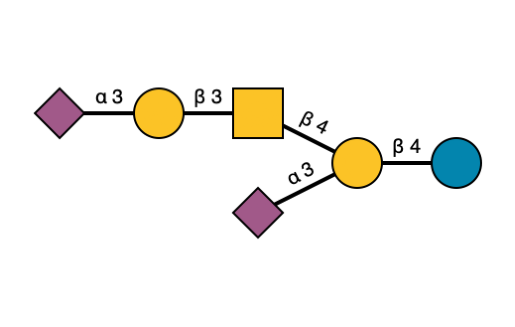

In [6]:
glycan = gl.glycan("Neu5Ac(a2-3)Gal(b1-3)GalNAc(b1-4)[Neu5Ac(a2-3)]Gal(b1-4)Glc", "GD1a")
glycan.show()

Next we can glycosylate the membrane using the `glycosylate` function (or the `attach` method). To do that we first need to set the root atom of the glycan to be `C1` of the first resdiue. This is because glycosylation will always attach the glycan's root atom to the scaffold. 

In [9]:
glycan.root_atom = glycan.get_atom("C1", residue=1)

Let's say we want to glycosylate all _ceramides_ in the upper layer of the membrane. Luckily, the membrane we loaded has defined the two layers as separate chains so we can get all ceramides to glycosylate using:

In [10]:
# all ceramides in the upper leaflet (chain U)
ceramides = membrane.get_residues("CER", chain="U")
len(ceramides)

10

Next we need to think of a linkage between the glycan and the ceramides. Luckily, glycans are attached via the `O1` of the ceramide in a typical linkage. So we can make the linkage like so:

In [12]:
link = gl.linkage("O1", "C1", ["HO1"], ["O1", "HO1"])

In [13]:
membrane_glycosylated = membrane.attach(glycan, link, residues=ceramides)

Let's see how many glycans we attached

In [14]:
membrane_glycosylated.glycans

defaultdict(dict,
            {Atom(O1, 277): Glycan(GD1a),
             Atom(O1, 381): Glycan(GD1a),
             Atom(O1, 1963): Glycan(GD1a),
             Atom(O1, 2067): Glycan(GD1a),
             Atom(O1, 2447): Glycan(GD1a),
             Atom(O1, 2551): Glycan(GD1a),
             Atom(O1, 2749): Glycan(GD1a),
             Atom(O1, 3291): Glycan(GD1a),
             Atom(O1, 3563): Glycan(GD1a),
             Atom(O1, 3949): Glycan(GD1a)})

Now that we have a basic glycosylated protein we can save it to a new PDB file

In [15]:
membrane_glycosylated.to_pdb("membrane_glycosylated.pdb")

### Optimizing the glycosylated membrane

If we inspect the PDB file we find that some of the glycans look rather sad. That is because the geometry of the protein as well as the presence of other glycans is not really considered when attaching glycans. However, we can address these issues by optimizing the structure now. 

Glycosylator uses Biobuild's optimization framework to improve the glycan conformations. Be sure to check out the tutorial on optimization there to get more details. In short, to optimize structures we need to perform four steps: 

(1) make a graph representation of the molecule to optimize 

(2) choose bonds to rotate around in order to optimize the conformation

(3) select an optimization environment to evaluate the quality of our conformations

(4) solve the environment to find a good conformation


Here we will outline how we can do this for our glycosylated protein:

In [17]:
# glycosylator comes with a pre-made function to perform steps 1 and 2 automatically. 
# It produces a ResidueGraph for the scaffold and a list of edges that belong to the glycan residues, for optimization.
graph, edges = gl.optimizers.make_scaffold_graph(membrane_glycosylated, only_clashing_glycans=True)

Now that we have a graph and edges, we need to setup a an environment. Glycosylator has multiple environments that we can use. We will use the default `DistanceRotatron` which uses geomeric reasoning to evaluate conformations. There are a few hyperparameters we might need to tinker with until we get a good result...

In [19]:
env = gl.optimizers.DistanceRotatron(graph, edges, pushback=4, crop_nodes_further_than=1.2, radius=40)

Now we can use the environment to optimize our glycoprotein. We can use the `optimize` function to solve the environment using an optimization algorithm. We will use a particle-swarm optimization. We could pass more arguments here to further guide the behavior of the swarm optimization...

In [21]:
optimized = gl.optimizers.optimize(membrane_glycosylated, env, "swarm")
optimized.to_pdb("membrane_glycosylated.optimized.pdb")

That's for this tutorial. You can now glycosylate your own membranes. Of course, the part about optimization is only illustrative and you may need to tinker around to fit it to your system. Good luck using Glycosylator in your project!